In [1]:
import collections
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import time
import json

from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Sat Oct 23 23:00:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |    347MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## download and setup data

In [5]:
# Download remote zip file
def download_files(origin):
    cwd = os.path.abspath(".")
    fname = cwd + "/" + os.path.splitext(os.path.basename(origin))[0]+".zip"
    if not os.path.exists(fname):
        zip_file = tf.keras.utils.get_file(fname=fname, cache_subdir=cwd, origin=origin, extract=True)
        os.remove(zip_file)

# MS-COCO 2017 zip files from https://cocodataset.org/#download
annotations_zip = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
train_images_zip = "http://images.cocodataset.org/zips/train2017.zip"
val_images_zip = "http://images.cocodataset.org/zips/val2017.zip"

download_files(annotations_zip)
#download_files(train_images_zip)

252919808/252907541 [==============================] - 17s 0us/step


In [6]:
annotation_file = os.path.abspath(".") + "/annotations/captions_train2017.json"
image_path = os.path.abspath(".") + "/train2017/"

USE_SUBSET = True

with open(annotation_file, "r") as f:
    annotations = json.load(f)

data_dict = collections.defaultdict(list)
for image in annotations["annotations"]:
    caption = f"<start> {image['caption']} <end>"
    path = image_path + f"{image['image_id']:012d}.jpg"
    data_dict[path].append(caption)

# if use subset then use 5000 images
if USE_SUBSET:
    data_subset = list(data_dict.keys())
    random.shuffle(data_subset)
    data_subset = data_subset[:5000]
else:
    data_subset = list(data_dict.keys())
    
data_x = []
data_y = []

#for path, captions in data_dict.items():
for path in data_subset:
    data_x.extend([path] * len(data_dict[path]))
    data_y.extend(data_dict[path])
    
print("data_list:", len(data_dict))
print("data_x:", len(data_x))
print("data_y:", len(data_y))
print("avg_caption_per_image:", f"{len(data_x)/len(data_subset):0.4f}")

data_list: 118287
data_x: 25008
data_y: 25008
avg_caption_per_image: 5.0016


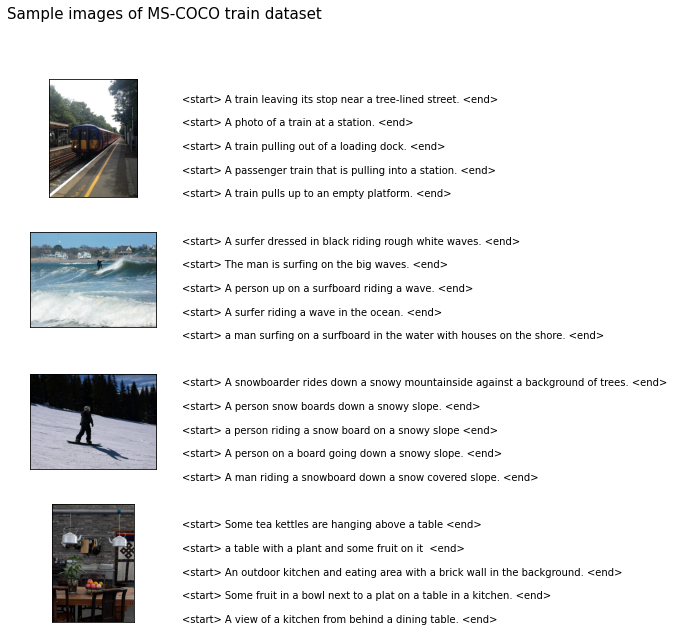

In [7]:
image_samples = np.random.randint(0, high=len(data_dict)-1, size=4)
count = 1

fig = plt.figure(figsize=(5, 10))
for i, idx in enumerate(image_samples):
    img = list(data_dict.keys())[idx]
    captions = data_dict[img]
    
    axs = fig.add_subplot(4, 2, count, xticks=[], yticks=[])
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs.imshow(image)
    count += 1
    
    axs = fig.add_subplot(4, 2, count)
    plt.axis('off')
    axs.plot()
    axs.set_xlim(0, 1)
    axs.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        axs.text(0, i, caption, fontsize=10)
    count += 1
    
plt.suptitle("Sample images of MS-COCO train dataset", fontsize=15)
# plt.tight_layout()
plt.show()

In [8]:
train_captions = data_y

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
data_y = cap_vector

In [9]:
test_percent = 0.2
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=test_percent) 

print("x_train count:", len(x_train))
print("x_test count:", len(x_test))

x_train count: 20006
x_test count: 5002


In [10]:
batch_size = 128
train_shuffle_buffer_size = len(x_train)
test_shuffle_buffer_size = len(x_test)

def load_image(image_path, caption):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, caption

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

test_data = test_data.shuffle(buffer_size=test_shuffle_buffer_size)
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data", train_data)
print("test_data", test_data)

train_data <PrefetchDataset shapes: ((None, 299, 299, 3), (None, 48)), types: (tf.float32, tf.int32)>
test_data <PrefetchDataset shapes: ((None, 299, 299, 3), (None, 48)), types: (tf.float32, tf.int32)>


## build model

In [11]:
def build_inception(image_height, image_width, num_channels):
    input_shape = [image_height, image_width, num_channels] # height, width, channels
    tranfer_model_base = tf.keras.applications.inception_v3.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    tranfer_model_base.trainable = False
    return tranfer_model_base

In [12]:
image_height = 299
image_width = 299
num_channels = 3

inception = build_inception(299, 299, 3)

87924736/87910968 [==============================] - 0s 0us/step


In [13]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512 
vocab_size = top_k + 1
num_steps = len(data_x) // BATCH_SIZE

features_shape = 2048
attention_features_shape = 64

In [27]:
class CNN(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        # get features from inception
        x = inception(x)
        x = tf.reshape(x, (x.shape[0], -1))
        # want output shape to be the same as the word embedding dimension
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)


    def call(self, x, features, hidden, i):
    
        # first input to the RNN is the feature vector as in https://arxiv.org/pdf/1411.4555.pdf
        # otherwise, input to RNN is the word embedding
        if i > 0:
            x = self.embedding(x)
        else: 
            x = tf.expand_dims(x, 1)

        output, state = self.gru(x,hidden)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [28]:
encoder = CNN(embedding_dim)
decoder = RNN(embedding_dim, units, vocab_size)

## train model with subset of data

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [30]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [31]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(0, target.shape[1]):
            # passing the features through the decoder
            if i > 0:
                predictions, hidden = decoder(dec_input, features, hidden, i)
                loss += loss_function(target[:, i], predictions)
                dec_input = tf.expand_dims(target[:, i], 1)
            else:
                # case where the first input x to the decoder is the image features
                prediction, hidden = decoder(features, features, hidden, i)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [33]:
from tqdm import tqdm

EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(tqdm(train_data)):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  1%|          | 1/157 [01:03<2:44:20, 63.21s/it]

Epoch 1 Batch 0 Loss 2.0888


 64%|██████▍   | 101/157 [01:35<00:18,  3.01it/s]

Epoch 1 Batch 100 Loss 1.0111


100%|██████████| 157/157 [02:20<00:00,  1.12it/s]


Epoch 1 Loss 0.918205
Time taken for 1 epoch 141.26 sec



  1%|          | 1/157 [00:00<01:53,  1.37it/s]

Epoch 2 Batch 0 Loss 0.9318


 64%|██████▍   | 101/157 [00:33<00:18,  3.03it/s]

Epoch 2 Batch 100 Loss 0.9045


100%|██████████| 157/157 [00:51<00:00,  3.07it/s]


Epoch 2 Loss 0.733456
Time taken for 1 epoch 51.08 sec



  1%|          | 1/157 [00:00<01:33,  1.66it/s]

Epoch 3 Batch 0 Loss 0.8302


 64%|██████▍   | 101/157 [00:32<00:18,  3.02it/s]

Epoch 3 Batch 100 Loss 0.8386


100%|██████████| 157/157 [00:50<00:00,  3.09it/s]


Epoch 3 Loss 0.663839
Time taken for 1 epoch 50.89 sec



  1%|          | 1/157 [00:00<01:35,  1.63it/s]

Epoch 4 Batch 0 Loss 0.8065


 64%|██████▍   | 101/157 [00:33<00:18,  3.01it/s]

Epoch 4 Batch 100 Loss 0.7445


100%|██████████| 157/157 [00:50<00:00,  3.08it/s]


Epoch 4 Loss 0.616213
Time taken for 1 epoch 50.99 sec



  1%|          | 1/157 [00:00<01:42,  1.52it/s]

Epoch 5 Batch 0 Loss 0.7133


 64%|██████▍   | 101/157 [00:37<00:20,  2.71it/s]

Epoch 5 Batch 100 Loss 0.7567


100%|██████████| 157/157 [00:57<00:00,  2.71it/s]


Epoch 5 Loss 0.580725
Time taken for 1 epoch 58.00 sec



  1%|          | 1/157 [00:00<01:40,  1.55it/s]

Epoch 6 Batch 0 Loss 0.6839


 64%|██████▍   | 101/157 [00:43<00:28,  1.98it/s]

Epoch 6 Batch 100 Loss 0.6503


100%|██████████| 157/157 [01:09<00:00,  2.25it/s]


Epoch 6 Loss 0.549178
Time taken for 1 epoch 70.61 sec



  1%|          | 1/157 [00:00<01:56,  1.34it/s]

Epoch 7 Batch 0 Loss 0.6111


 64%|██████▍   | 101/157 [00:37<00:20,  2.75it/s]

Epoch 7 Batch 100 Loss 0.6904


100%|██████████| 157/157 [00:57<00:00,  2.74it/s]


Epoch 7 Loss 0.521492
Time taken for 1 epoch 57.36 sec



  1%|          | 1/157 [00:00<01:47,  1.45it/s]

Epoch 8 Batch 0 Loss 0.6157


 64%|██████▍   | 101/157 [00:40<00:23,  2.42it/s]

Epoch 8 Batch 100 Loss 0.6308


100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 8 Loss 0.492617
Time taken for 1 epoch 63.28 sec



  1%|          | 1/157 [00:00<01:47,  1.45it/s]

Epoch 9 Batch 0 Loss 0.5509


 64%|██████▍   | 101/157 [00:41<00:22,  2.50it/s]

Epoch 9 Batch 100 Loss 0.5772


100%|██████████| 157/157 [01:06<00:00,  2.36it/s]


Epoch 9 Loss 0.465506
Time taken for 1 epoch 66.51 sec



  1%|          | 1/157 [00:00<01:56,  1.34it/s]

Epoch 10 Batch 0 Loss 0.4849


 64%|██████▍   | 101/157 [00:48<00:27,  2.03it/s]

Epoch 10 Batch 100 Loss 0.5440


100%|██████████| 157/157 [01:15<00:00,  2.09it/s]

Epoch 10 Loss 0.440709
Time taken for 1 epoch 75.30 sec



## evalute training and examples

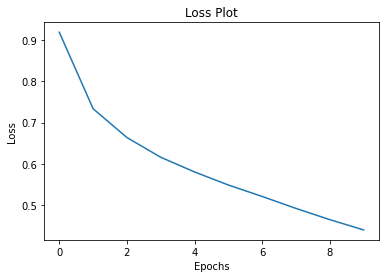

In [34]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Caption: <start> a bathroom with two different styles of toilets <end>
Prediction Caption: a bathroom with marble tile floor and a shower curtain <end>


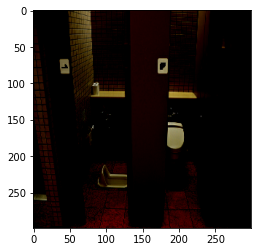

In [45]:
def evaluate(image, caption):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = load_image(image, caption)[0]

    image = tf.expand_dims(temp_input, axis=0)
    features = encoder(image)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length+1):
        if i > 0: 
            predictions, hidden = decoder(dec_input,features,hidden,i)
            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            result.append(tokenizer.index_word[predicted_id])
            if tokenizer.index_word[predicted_id] == '<end>':
                return result
            dec_input = tf.expand_dims([predicted_id], 0)
        else:
            predictions, hidden = decoder(features,
                                                          features,
                                                          hidden,i)
    return result

# example caption
rid = np.random.randint(0, len(x_train))
image = x_train[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in y_train[rid] if i not in [0]])


result = evaluate(image, real_caption)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plt.imshow(load_image(image, caption)[0])